In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Scikit-learn imports
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score, make_scorer
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

# PyTorch Geometric imports
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, GCNConv, SAGEConv
from torch_geometric.utils import to_networkx
# PyTorch TabNet
from pytorch_tabnet.tab_model import TabNetRegressor

# NetworkX for graph manipulation
import networkx as nx

# Hyperopt for hyperparameter optimization
from hyperopt import fmin, tpe, hp, Trials

import sys
import os

# Add the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from pre_processing import preprocess_data

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

## **Task Description:** 
### Predict the total number of kills in terrorist incidents using the Global Terrorism Database (GTD) based on various features such as location, weapons used, perpetrator group, attack type, and other relevant factors.

In [2]:
def load_data():
    dataset = pd.read_excel(r"globalterrorismdb_2021Jan-June_1222dist.xlsx") # 2021-2021 June
    return dataset


- Computes and visualizes feature importances based on model type and plots them as horizontal bar charts for each model.

In [3]:
def plot_feature_importances(models, X_columns, model_types, layer_names=None, titles=None):

    fig, axes = plt.subplots(4, 2, figsize=(15, 20))
    axes = axes.flatten()  # Flatten the axes for easier indexing

    for idx, model in enumerate(models):
        model_type = model_types[idx]
        layer_name = layer_names[idx] if layer_names else None
        title = titles[idx] if titles else f"Model {idx+1} Feature Importances"

        # Compute feature importances based on model type
        if model_type == "gnn":
            if not layer_name:
                raise ValueError("For GNN, 'layer_name' must be provided.")
            # Extract weights from GNN layer
            conv_left_weights = getattr(model, layer_name).lin_l.weight.data.cpu().numpy()
            conv_right_weights = getattr(model, layer_name).lin_r.weight.data.cpu().numpy()
            conv_weights = np.abs(conv_left_weights).sum(axis=0) + np.abs(conv_right_weights).sum(axis=0)
            importances = conv_weights

        elif model_type == "mlp":
            if not layer_name:
                raise ValueError("For MLP, 'layer_name' must be provided.")
            # Extract weights from MLP layer
            fc_weights = getattr(model, layer_name).weight.data.cpu().numpy()
            importances = np.abs(fc_weights).sum(axis=0)

        elif model_type == "tabnet":
            # Extract feature importances directly from TabNet model
            importances = model.feature_importances_

        elif model_type in {"rf", "gb"}:  
            # Extract feature importances from tree-based models
            importances = model.feature_importances_

        elif model_type == "linear":  # Linear Regression, Ridge, etc.
            # Extract absolute coefficients for linear models
            if hasattr(model, "coef_"):
                importances = np.abs(model.coef_)
            else:
                raise ValueError("The model does not have coefficients. Ensure it's a linear model.")
        
        else:
            raise ValueError(f"Unsupported model type: {model_type}")

        # Create DataFrame for feature importances
        feature_importance_df = pd.DataFrame({
            'Feature': X_columns,
            'Importance': importances
        })

        # Sort the feature importances in descending order
        feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

        # Plot Feature Importances
        axes[idx].barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
        axes[idx].invert_yaxis()  # Reverse the order to show most important on top
        axes[idx].set_xlabel('Importance')
        axes[idx].set_ylabel('Feature')
        axes[idx].set_title(title)

    # Hide any unused subplots
    for i in range(len(models), 6):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

- **evaluate_model():** Evaluates the performance of a given model using Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and R² score on the test set. This function handles different types of models and returns predictions alongside performance metrics.

- **plot_results():** Plots the actual vs predicted values for all the models. It uses scatter plots to visualize the model's predictions against the true values, and includes performance metrics such as R², MAE, and RMSE.

In [4]:
def evaluate_model(model, X_test, y_test):
    if model == tabnet_model:
        y_test = y_test.reshape(-1,1)

    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return y_pred, mae, rmse, r2

def plot_results(y_test, X_test, gnn_y_test, lr_model, rf_model, gb_model, rr_model, tabnet_model, MLP_model, GNN_model):

    plt.figure(figsize=(15, 5))
    
    # ML
    lr_y_pred, lr_mae, lr_rmse, lr_r2 = evaluate_model(lr_model, X_test, y_test)
    rr_y_pred, rr_mae, rr_rmse, rr_r2 = evaluate_model(rr_model, X_test, y_test)
    rf_y_pred, rf_mae, rf_rmse, rf_r2 = evaluate_model(rf_model, X_test, y_test)
    gb_y_pred, gb_mae, gb_rmse, gb_r2 = evaluate_model(gb_model, X_test, y_test)

    # DL
    tn_y_pred, tn_mae, tn_rmse, tn_r2 = evaluate_model(tabnet_model, X_test, y_test)
    mlp_y_pred, mlp_mae, mlp_rmse, mlp_r2 = MLP_model
    gnn_y_pred, gnn_mae, gnn_rmse, gnn_r2 = GNN_model


    metrics = [
        (lr_r2, lr_mae, lr_rmse, "red", "Linear Regression"),
        (rr_r2, rr_mae, rr_rmse, "orange", "Ridge Regression"),
        (rf_r2, rf_mae, rf_rmse, "blue", "Random Forest"),
        (gb_r2, gb_mae, gb_rmse, "green", "Gradient Boosting"),
        (tn_r2, tn_mae, tn_rmse, "purple", "Tabnet"),
        (mlp_r2, mlp_mae, mlp_rmse, "teal", "MLP"),
        (gnn_r2, gnn_mae, gnn_rmse, "magenta", "GNN"),
    ]
    
    for i, (score, mae, rmse, c, title) in enumerate(metrics):
        if title == "GNN":
            y_test = gnn_y_test
    
        plt.subplot(3, 4, i + 1)
        y_pred = [lr_y_pred, rr_y_pred, rf_y_pred, gb_y_pred, tn_y_pred, mlp_y_pred, gnn_y_pred][i]
        plt.scatter(y_test, y_pred, color= c, label="Predicted", alpha=0.5, s=60)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', label='Perfect Prediction', linewidth=2)
        plt.title(title)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
       
        plt.grid()

        plt.text(0.5, -0.4, f"R² Score: {round(float(score), 2)}", ha='center', va='bottom', transform=plt.gca().transAxes, fontsize=12)
        plt.text(0.5, -0.5, f"Mean Absolute Error: {round(float(mae), 2)}", ha='center', va='bottom', transform=plt.gca().transAxes, fontsize=12)
        plt.text(0.5, -0.6, f"Root Mean Squared Error: {round(float(rmse), 2)}", ha='center', va='bottom', transform=plt.gca().transAxes, fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(bottom=-1.2)
    plt.show()

def plot_loss(tn_train_losses, tn_val_losses, mlp_train_losses, mlp_val_losses, gnn_train_losses, gnn_val_losses):

    plt.figure(figsize=(15, 5))

    plt.subplot(2, 3, 1)
    plt.plot(tn_train_losses, color='blue', label='Training Loss')
    plt.plot(tn_val_losses, color='orange', label='RMSE')
    plt.title('TabNet: Training and RMSE Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.subplot(2, 3, 2) 
    plt.plot(mlp_train_losses, color='blue', label='Training Loss')
    plt.plot(mlp_val_losses, color='orange', label='Validation Loss')
    plt.title('MLP: Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.subplot(2, 3, 3)
    plt.plot(gnn_train_losses, color='blue', label='Training Loss')
    plt.plot(gnn_val_losses, color='orange', label='Validation Loss')
    plt.title('GNN: Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

 
    plt.tight_layout()
    plt.show()

## Data Loading and Preprocessing

In [5]:
dataset = load_data()
X, y, dataset = preprocess_data(dataset)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=23)
dataset.head()

,success,gname_freq,city_freq,country_freq,attacktype1_score,targtype1_score,weaptype1_score,gname_score,country_score,city_score,...,nkill_likelihood_score,region_3,region_5,region_6,region_8,region_9,region_10,region_11,region_12,nkill
0,1.0,0.228571,0.066667,0.167228,0.875,1.000000,0.857143,0.977778,0.948718,0.123077,...,0.589934,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0
1,1.0,0.121429,0.033333,0.096521,0.500,0.842105,0.857143,0.911111,0.871795,0.030769,...,0.347526,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1.0,0.000000,0.033333,0.159371,0.875,0.894737,0.857143,0.000000,0.641026,0.015385,...,0.477050,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.121429,0.033333,0.096521,0.875,0.894737,0.857143,0.911111,0.871795,0.092308,...,0.503175,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6.0
4,1.0,0.000000,0.033333,0.093154,0.875,1.000000,0.857143,0.022222,0.743590,0.030769,...,0.543654,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


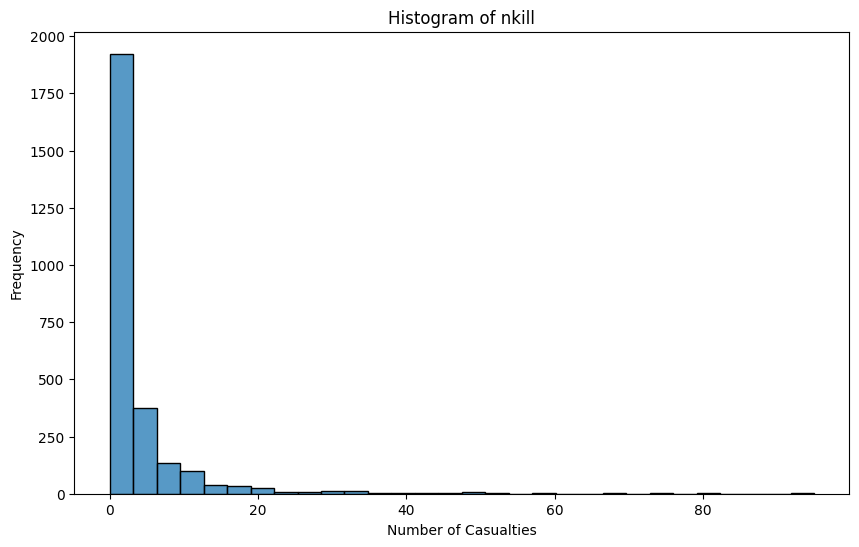

In [6]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(dataset['nkill'], kde=False, bins=30)
plt.title('Histogram of nkill')
plt.xlabel('Number of Casualties')
plt.ylabel('Frequency')
plt.show()

C:\Users\rma81\AppData\Local\Temp\ipykernel_19648\1665960361.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dataset['nkill'], shade=True)


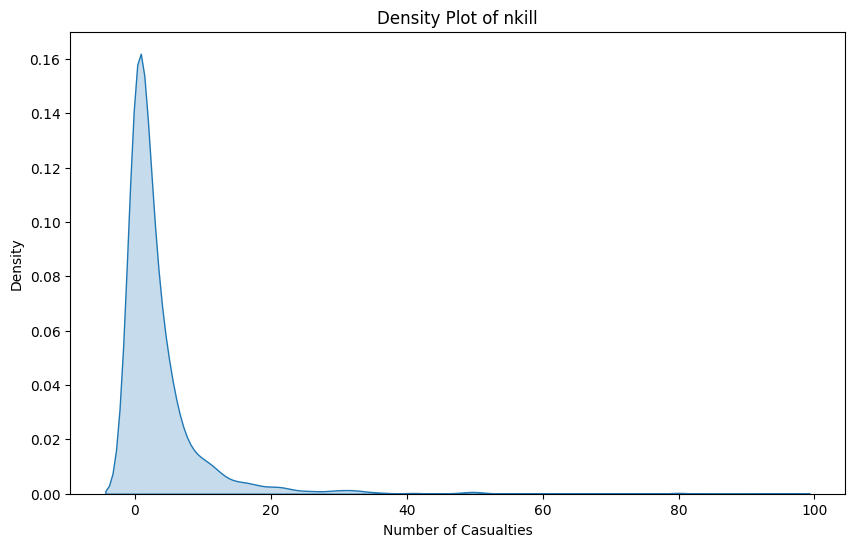

In [7]:
# Density plot (Kernel Density Estimate)
plt.figure(figsize=(10, 6))
sns.kdeplot(dataset['nkill'], shade=True)
plt.title('Density Plot of nkill')
plt.xlabel('Number of Casualties')
plt.ylabel('Density')
plt.show()


In [8]:
column_names = dataset.drop('nkill', axis=1).columns
X_dataframe= pd.DataFrame(X, columns=column_names)


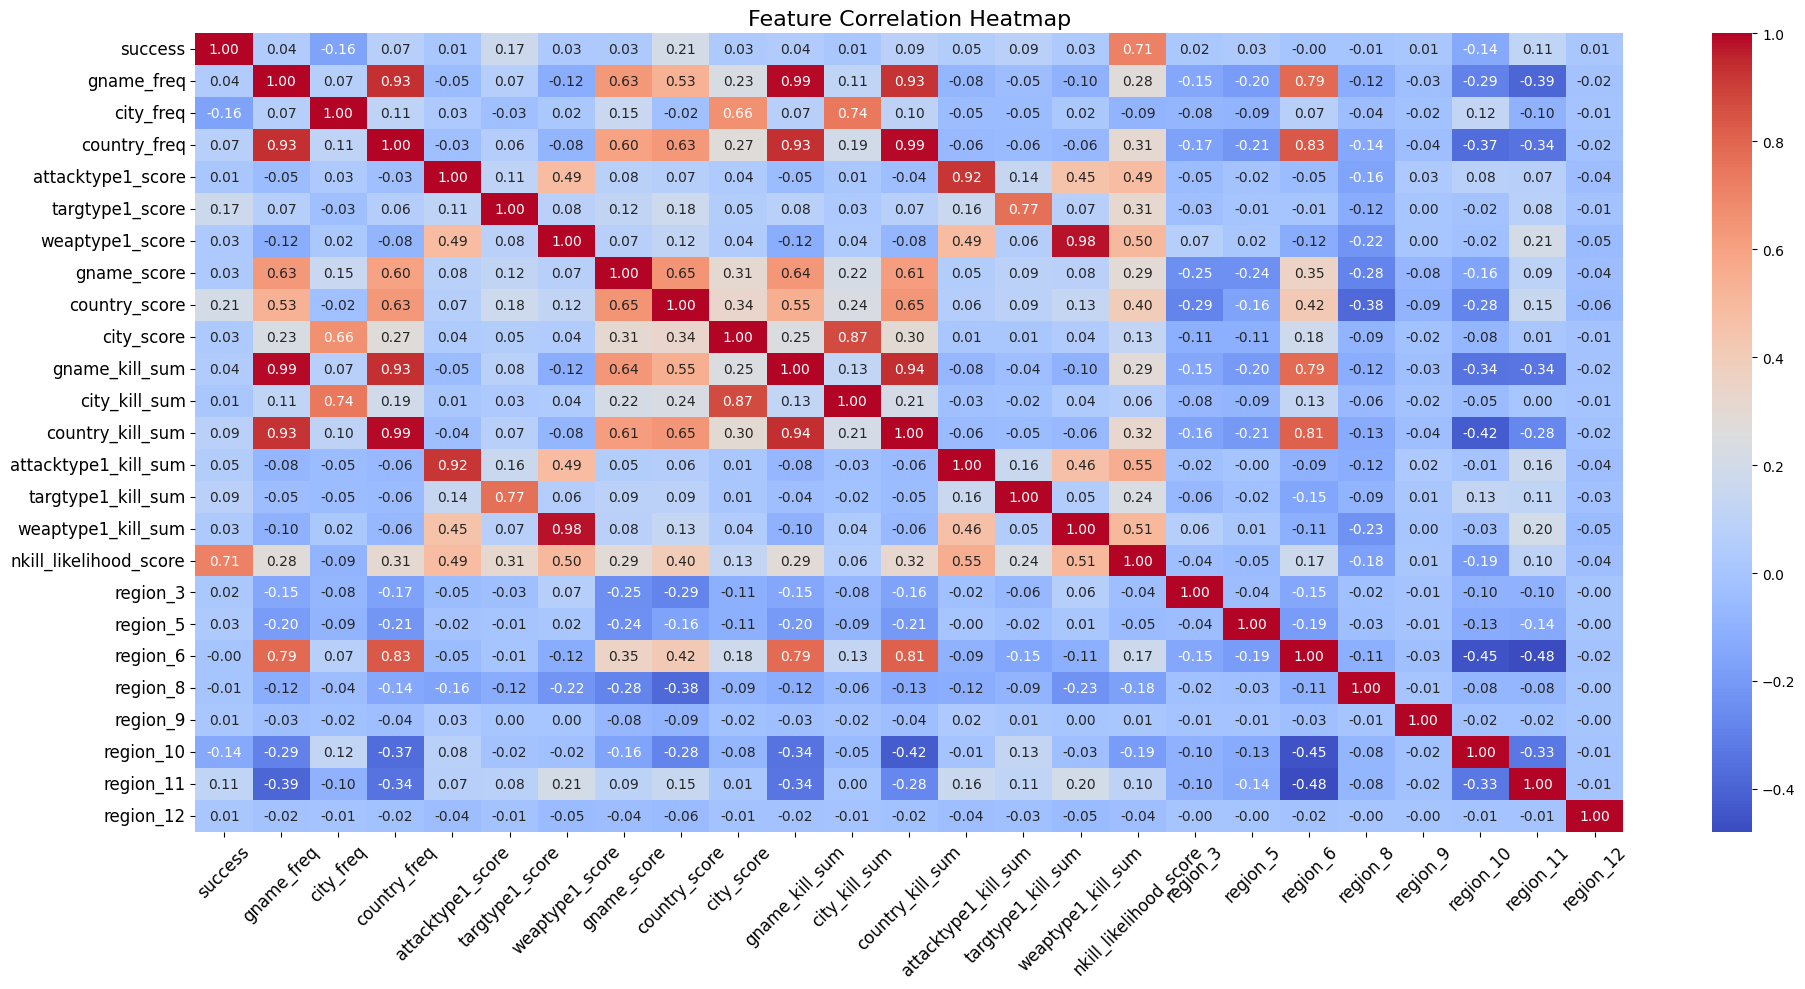

In [9]:

corr = X_dataframe.corr()

plt.figure(figsize=(20, 10))  
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", annot_kws={"size": 10})  # Adjust font size in `annot_kws`
plt.title("Feature Correlation Heatmap", fontsize=16) 
plt.xticks(fontsize=12, rotation=45) 
plt.yticks(fontsize=12) 
plt.tight_layout()  

plt.show()


## ML: 
### Linear Regression, Ridge Regression, Random Forrest, Gradient Boosting    


In [10]:
lr_model = LinearRegression()
print("Linear Regression Model...")
lr_model.fit(X_train, y_train)

rr_model = Ridge(alpha=7.0)
print("Linear Regression Model...")
rr_model.fit(X_train, y_train)

rf_model = RandomForestRegressor(max_depth = 10, min_samples_split = 2, n_estimators = 200, random_state = 42)
print("Training Random Forest Model...")
rf_model.fit(X_train, y_train)

gb_model = GradientBoostingRegressor(max_depth = 7, n_estimators = 500, learning_rate=0.01, random_state = 42)
print("Training Gradient Boosting Model...")
gb_model.fit(X_train, y_train)


Linear Regression Model...
Linear Regression Model...
Training Random Forest Model...
Training Gradient Boosting Model...


GradientBoostingRegressor(learning_rate=0.01, max_depth=7, n_estimators=500,
                          random_state=42)

## TabNet


In [11]:
tabnet_model = TabNetRegressor(
    n_d=32,               # Increased width of the decision prediction layer
    n_a=48,             # Width of the attention embedding for each mask 
    n_steps=8,            # Number of steps in the architecture
    gamma= 1.5494,            # Relaxation factor
    lambda_sparse= 0.0215,   # Sparsity regularization
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.0371, weight_decay=0.1662),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type="entmax"    # Other options: "sparsemax"
)

# Train the final model on the full training data
tabnet_model.fit(
    X_train=X_train, 
    y_train=y_train.reshape(-1, 1),
    eval_set=[(X_val, y_val.reshape(-1, 1))],
    eval_name=['val'],
    eval_metric=['rmse'],
    max_epochs=70,
    patience=15,
    batch_size=64,
    virtual_batch_size=32,
    num_workers=3,
    drop_last=True
)

history_data = tabnet_model.history.history
tn_train_losses = history_data['loss']
tn_val_losses = history_data['val_rmse']


c:\Users\rma81\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 62.85584| val_rmse: 7.15196 |  0:00:16s
epoch 1  | loss: 44.45059| val_rmse: 7.31618 |  0:00:31s
epoch 2  | loss: 38.53761| val_rmse: 7.42021 |  0:00:49s
epoch 3  | loss: 37.99507| val_rmse: 7.73388 |  0:01:07s
epoch 4  | loss: 43.00766| val_rmse: 7.51336 |  0:01:24s
epoch 5  | loss: 37.26138| val_rmse: 7.11661 |  0:01:42s
epoch 6  | loss: 35.25141| val_rmse: 7.33257 |  0:01:59s
epoch 7  | loss: 36.25644| val_rmse: 7.31041 |  0:02:16s
epoch 8  | loss: 36.04913| val_rmse: 7.32144 |  0:02:34s
epoch 9  | loss: 34.09805| val_rmse: 7.21916 |  0:02:51s
epoch 10 | loss: 37.42062| val_rmse: 5.28885 |  0:03:09s
epoch 11 | loss: 35.82257| val_rmse: 5.69998 |  0:03:26s
epoch 12 | loss: 39.11854| val_rmse: 6.88427 |  0:03:43s
epoch 13 | loss: 38.75496| val_rmse: 6.43113 |  0:04:01s
epoch 14 | loss: 35.32554| val_rmse: 5.27104 |  0:04:18s
epoch 15 | loss: 34.1618 | val_rmse: 5.77643 |  0:04:36s
epoch 16 | loss: 35.14325| val_rmse: 6.35668 |  0:04:53s
epoch 17 | loss: 32.54448| val_

c:\Users\rma81\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


## MLP


In [12]:
class TerrorismDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1 = 128, hidden_dim2 = 64, dropout_rate = 0.2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.relu1 = torch.nn.LeakyReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.relu2 = torch.nn.LeakyReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_dim2, 1)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu2(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

def train_model(model, train_loader, val_loader,num_epochs =10, lr = 0.005, weight_decay = 1e-4):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=3)
    
    train_losses = [] 
    val_losses = [] 

    lowest_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(num_epochs):

        model.train()
        batch_train_losses = []
        train_preds, train_labels = [], []

        for X_train, y_train in train_loader:
            X_train, y_train = X_train.to(device), y_train.to(device)
            
            outputs = model(X_train)
            train_loss = criterion(outputs, y_train)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            batch_train_losses.append(train_loss.item())
            train_preds.extend(outputs.cpu().detach().numpy())
            train_labels.extend(y_train.cpu().numpy())

        # Average train loss for the epoch
        epoch_train_loss = np.mean(batch_train_losses)
        train_losses.append(epoch_train_loss)

        model.eval()
        batch_val_losses = []
        val_preds, val_labels = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                
                val_outputs = model(X_val)
                val_loss = criterion(val_outputs, y_val)
                
                batch_val_losses.append(val_loss.item())
                
                val_preds.extend(val_outputs.cpu().numpy())
                val_labels.extend(y_val.cpu().numpy())

        # Average validation loss for the epoch
        epoch_val_loss = np.mean(batch_val_losses)
        val_losses.append(epoch_val_loss)

        # evaluation metrics
        r2 = r2_score(y_true=val_labels, y_pred=val_preds)
        mae = mean_absolute_error(y_true=val_labels, y_pred=val_preds)
        rmse = root_mean_squared_error(val_labels, val_preds)
   
        # Step the scheduler based on validation loss
        scheduler.step(epoch_val_loss)

        # Early stopping logic
        if epoch_val_loss < lowest_val_loss:
            lowest_val_loss = epoch_val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        # Break if validation loss doesn't improve for 'patience' epochs
        if epochs_without_improvement >= 25:
            print(f"At Epoch: {epoch}, Early stopping triggered after {epochs_without_improvement} epochs without improvement!")
            break

        if epoch % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

    return train_losses, val_losses, val_preds, mae, rmse, r2

# Convert to Dataset and DataLoader
train_dataset = TerrorismDataset(X_train, y_train)
test_dataset = TerrorismDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model with the best hyperparameters
mlp_model = MLP(input_dim=X_train.shape[1],
                 hidden_dim1=224,
                 hidden_dim2=64,
                 dropout_rate=0.108).to(device)


# Train the best model
mlp_train_losses, mlp_val_losses, mlp_preds, mlp_mae, mlp_rmse, mlp_r2 = train_model(mlp_model, train_loader, val_loader, num_epochs=500, lr=0.00676, weight_decay=0.0151)


Epoch [1/500], Train Loss: 43.9161, Val Loss: 50.4001
Epoch [11/500], Train Loss: 24.1543, Val Loss: 21.2946
Epoch [21/500], Train Loss: 23.1390, Val Loss: 17.4446
Epoch [31/500], Train Loss: 19.4993, Val Loss: 13.5845
Epoch [41/500], Train Loss: 17.7641, Val Loss: 12.3106
Epoch [51/500], Train Loss: 16.1274, Val Loss: 11.6412
Epoch [61/500], Train Loss: 16.4406, Val Loss: 12.3843
Epoch [71/500], Train Loss: 16.1594, Val Loss: 10.5233
Epoch [81/500], Train Loss: 15.2740, Val Loss: 11.6779
Epoch [91/500], Train Loss: 14.8781, Val Loss: 10.7070
Epoch [101/500], Train Loss: 14.2364, Val Loss: 10.9129
Epoch [111/500], Train Loss: 14.1284, Val Loss: 9.9859
Epoch [121/500], Train Loss: 13.3874, Val Loss: 10.0684
Epoch [131/500], Train Loss: 13.8128, Val Loss: 10.0528
Epoch [141/500], Train Loss: 13.9484, Val Loss: 10.1782
Epoch [151/500], Train Loss: 13.6837, Val Loss: 10.0005
At Epoch: 153, Early stopping triggered after 25 epochs without improvement!


## GNN

In [13]:
class GNNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channel1 = 64, hidden_channel2 = 64, out_channels = 1, dropout=0.3):
        super(GNNModel, self).__init__()
   
        self.conv1 = SAGEConv(in_channels, hidden_channel1)
        self.conv2 = SAGEConv(hidden_channel1, hidden_channel2)
  
        self.dropout = torch.nn.Dropout(p = dropout)

        self.projection = torch.nn.Linear(in_channels,hidden_channel2)

        self.fc1 = torch.nn.Linear(hidden_channel2, 64)
        self.fc2 = torch.nn.Linear(64, out_channels)
        
    def forward(self, x, edge_index):
        x_initial = x  # Save the input features for the skip connection
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x_initial = self.projection(x_initial)
        x = x + x_initial  # Add the skip connection
        x = F.elu(x)
        x = self.dropout(x)

        # Apply MLP layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = self.fc2(x)
        
        return x

- Converts tabular data into a graph using the k-Nearest Neighbors (k-NN) algorithm. The graph nodes represent rows of the dataset, and edges represent k-NN connections. It outputs a torch_geometric.data.Data object containing node features, edges, and target labels.

In [14]:


def create_graph_from_data(X, y, k = 6, metric = "euclidean"):
    num_nodes = X.shape[0]

    knn = NearestNeighbors(n_neighbors=k + 1, metric= metric)
    knn.fit(X)
    distances, indices = knn.kneighbors(X)

    graph = nx.Graph()

    # Add nodes with features
    for i in range(num_nodes):
        graph.add_node(i, x=X[i])

    # Add edges based on KNN
    for i in range(num_nodes):
        for j in indices[i][1:]:  # Skip the first neighbor (self-loop)
            graph.add_edge(i, j)

    # Extract edge index and node features
    edge_index = torch.tensor(list(graph.edges)).t().contiguous()
    # Add reverse edges to make it undirected
    edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
    node_features = torch.tensor(np.array([graph.nodes[i]['x'] for i in range(num_nodes)]), dtype=torch.float)
    targets = torch.tensor(y, dtype=torch.float)

    # Create PyTorch Geometric Data object
    data = Data(x=node_features, edge_index=edge_index, y=targets)

    return data

- Splits the graph data into training and validation sets by creating boolean masks based on a random permutation of nodes.

In [15]:
def split_graph_data(dataset):
    torch.manual_seed(42)

    indices = torch.randperm(dataset.num_nodes)

    train_size = int(dataset.num_nodes * 0.8)

    # Create boolean masks
    train_mask = torch.zeros(dataset.num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(dataset.num_nodes, dtype=torch.bool)

    # set masks
    train_mask[indices[:train_size]] = True
    val_mask[indices[train_size:]] = True

    return train_mask, val_mask

In [16]:
def train_GNN(model, train_mask, val_mask, dataset, num_epochs=50, patience=10, lr=0.001, weight_decay = 0.05):
    # Initialize optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.7, verbose=True)

    # Define loss function
    criterion = torch.nn.MSELoss()

    # Lists to store losses
    train_losses = []
    val_losses = []

    # Variables for early stopping
    best_rmse = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        optimizer.zero_grad()
        out = model(dataset.x, dataset.edge_index).squeeze()
        train_loss = criterion(out[train_mask], dataset.y[train_mask])
        train_loss.backward()
        optimizer.step()

        # Store training loss
        train_losses.append(train_loss.item())

        # Validation phase
        model.eval()
        with torch.no_grad():
            out = model(dataset.x, dataset.edge_index).squeeze()
            val_loss = criterion(out[val_mask], dataset.y[val_mask])
            val_losses.append(val_loss.item())

            # Make predictions and calculate metrics
            predictions = out[val_mask].cpu().numpy()
            true_values = dataset.y[val_mask].cpu().numpy()

            mae = mean_absolute_error(true_values, predictions)
            rmse = root_mean_squared_error(true_values, predictions)
            r2 = r2_score(true_values, predictions)

        # Early stopping logic
        if rmse < best_rmse:
            best_rmse = rmse
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}. No improvement for {patience} epochs.")
            break

        # Update learning rate scheduler based on validation RMSE
        scheduler.step(rmse)

        # Print progress every 10 epochs
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

    return train_losses, val_losses, predictions, mae, rmse, r2


dataset_gnn = create_graph_from_data(X,y)
train_mask, val_mask = split_graph_data(dataset_gnn)

print(f"Dataset\n------------------------")
print(f"Data structure: {dataset_gnn}")
print(f"Number of features: {dataset_gnn.num_features}")
print(f"Number of edges: {dataset_gnn.num_edges}")
print(f"Number of Nodes: {dataset_gnn.num_nodes}")
print(f"No of Train nodes: {train_mask.sum()}")
print(f"No of Val nodes: {val_mask.sum()}")
print(f"\n------------------------\n")

gnn_model = GNNModel(
    in_channels = dataset_gnn.num_node_features,
    hidden_channel1 = 432,
    hidden_channel2 = 80,
    dropout = 0.35
    ).to(device)
dataset_gnn = dataset_gnn.to(device)


gnn_train_losses, gnn_val_losses, gnn_preds, gnn_mae, gnn_rmse, gnn_r2 = train_GNN(
    gnn_model, train_mask, val_mask, dataset_gnn, num_epochs=500, patience=50, lr= 0.0168, weight_decay= 0.00698)


Dataset
------------------------
Data structure: Data(x=[2689, 25], edge_index=[2, 22812], y=[2689])
Number of features: 25
Number of edges: 22812
Number of Nodes: 2689
No of Train nodes: 2151
No of Val nodes: 538

------------------------

Epoch 0, Training Loss: 67.6812, Validation Loss: 33.1534, RMSE: 5.7579, R2: -0.0618
Epoch 10, Training Loss: 53.6049, Validation Loss: 30.7714, RMSE: 5.5472, R2: 0.0145
Epoch 20, Training Loss: 52.4651, Validation Loss: 29.4752, RMSE: 5.4291, R2: 0.0560
Epoch 30, Training Loss: 50.2659, Validation Loss: 26.2765, RMSE: 5.1261, R2: 0.1584
Epoch 40, Training Loss: 45.9531, Validation Loss: 24.5372, RMSE: 4.9535, R2: 0.2142
Epoch 50, Training Loss: 36.9279, Validation Loss: 19.0839, RMSE: 4.3685, R2: 0.3888
Epoch 60, Training Loss: 35.6891, Validation Loss: 17.0004, RMSE: 4.1232, R2: 0.4555
Epoch 70, Training Loss: 35.2718, Validation Loss: 16.9822, RMSE: 4.1210, R2: 0.4561
Epoch 80, Training Loss: 30.9299, Validation Loss: 15.1087, RMSE: 3.8870, R2: 0

## Final Evaluation

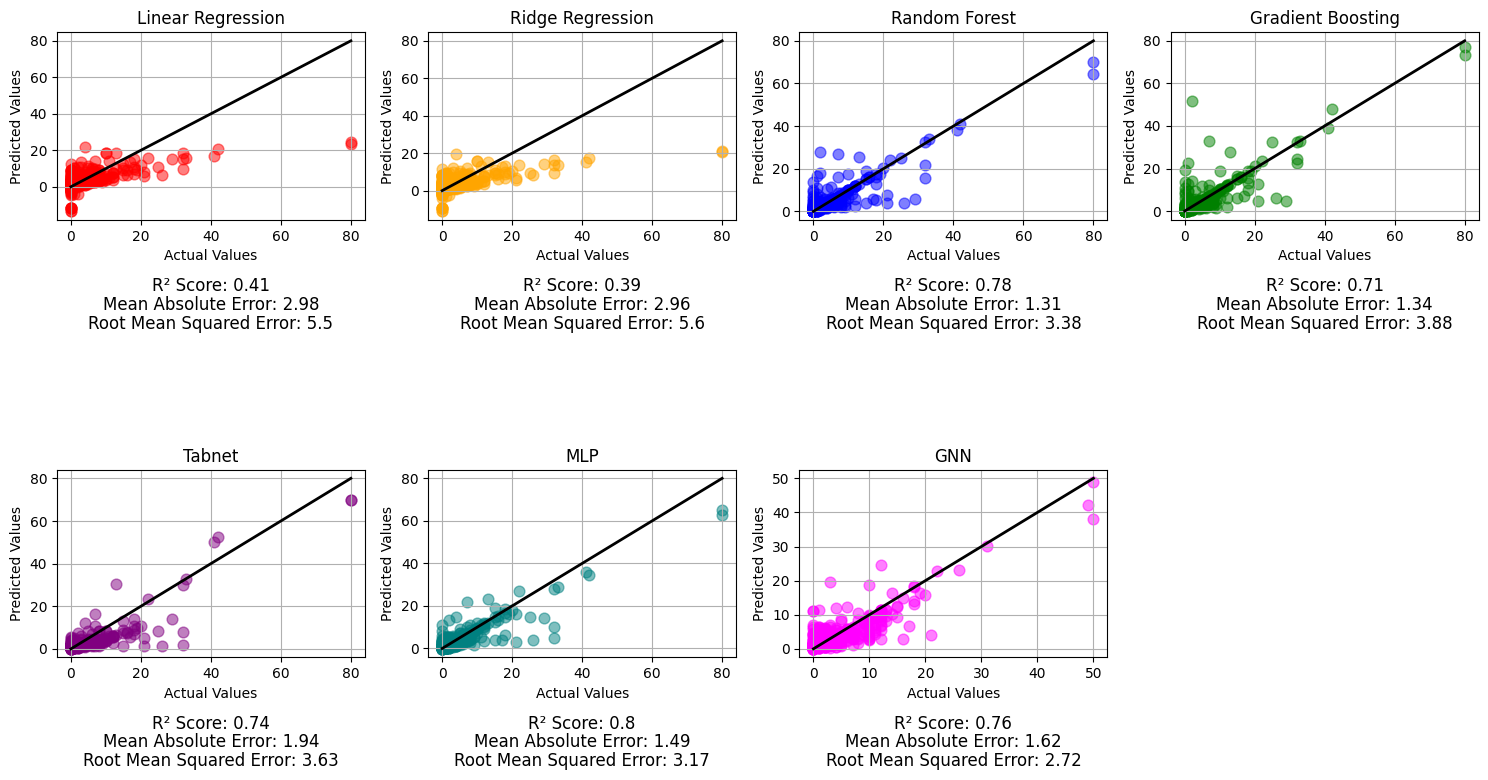

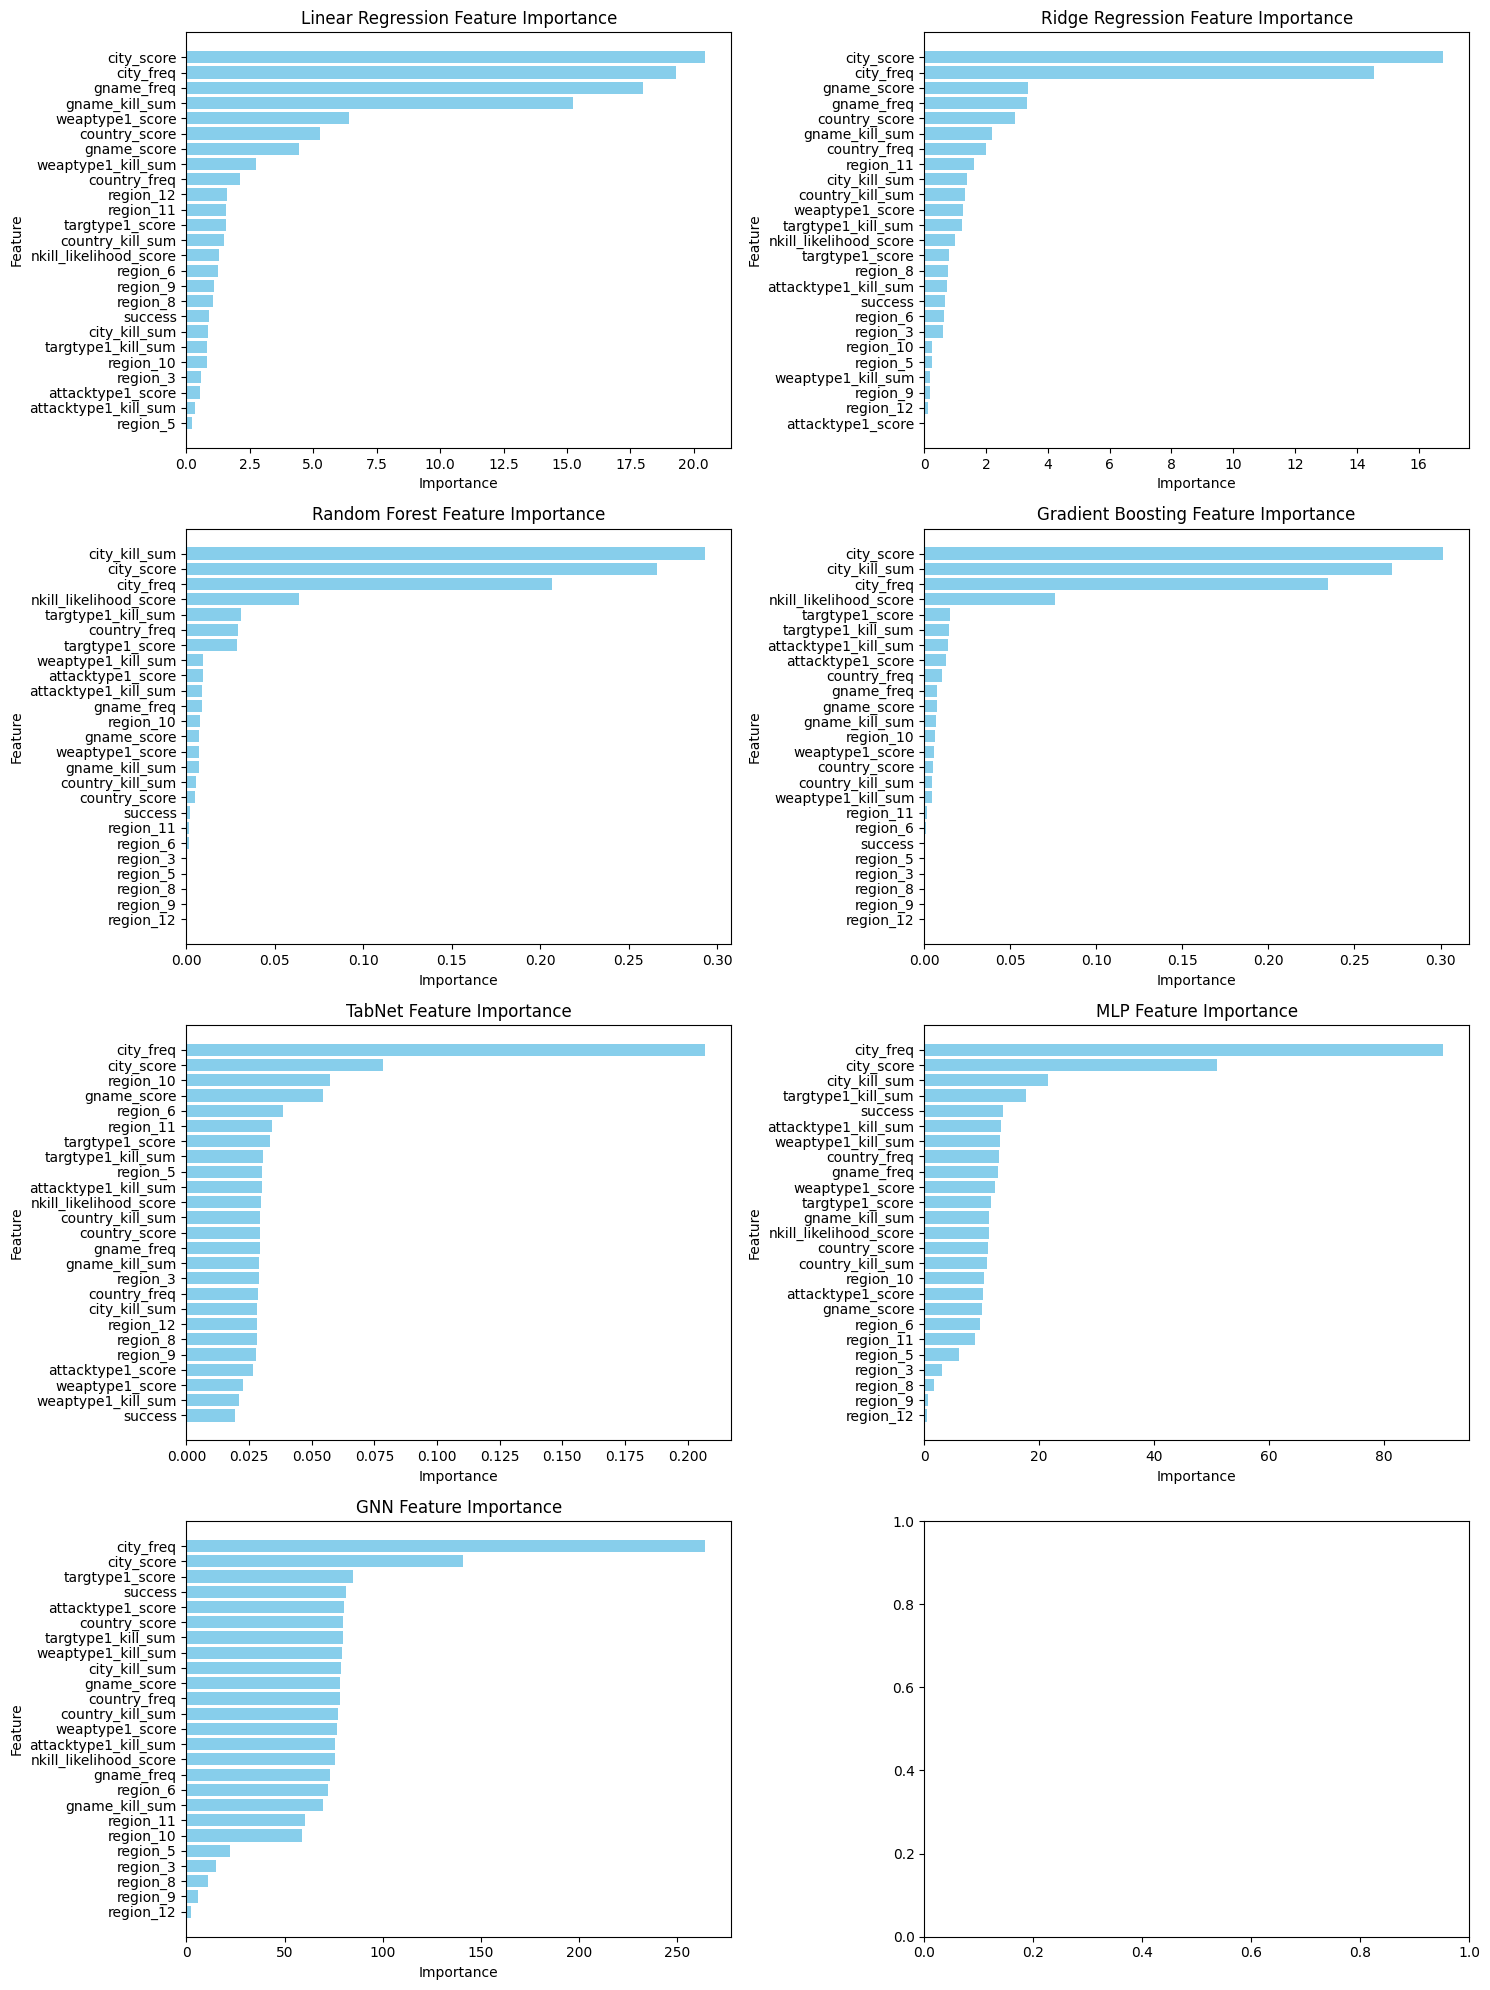

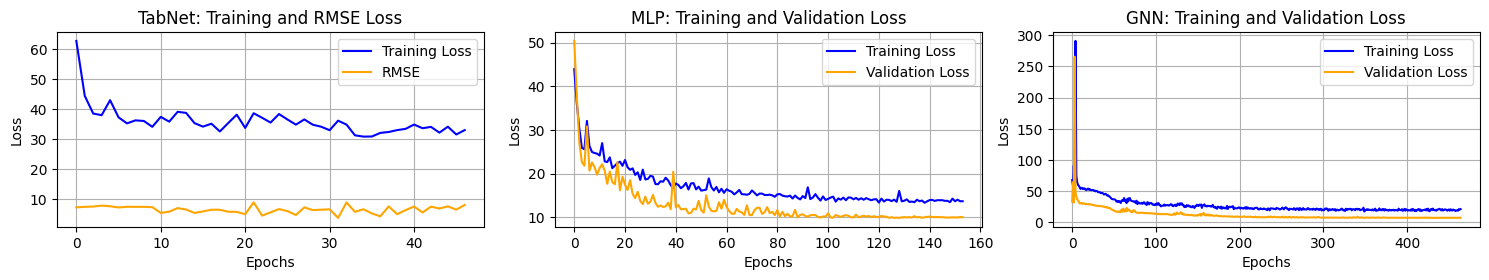

In [17]:
plot_results(
    y_val, X_val,
    dataset_gnn.y[val_mask].cpu().numpy(),  
    lr_model,
    rf_model,
    gb_model,
    rr_model,
    tabnet_model,
    [mlp_preds, mlp_mae, mlp_rmse, mlp_r2],
    [gnn_preds, gnn_mae, gnn_rmse, gnn_r2],
    )

plot_feature_importances(
    models=[lr_model, rr_model, rf_model, gb_model, tabnet_model, mlp_model, gnn_model],
    X_columns=X_dataframe.columns,
    model_types=["linear", "linear", "rf", "gb", "tabnet", "mlp", "gnn"],
    layer_names=[None, None, None, None, None, "fc1", "conv1"], 
    titles=[
        "Linear Regression Feature Importance",
        "Ridge Regression Feature Importance",
        "Random Forest Feature Importance",
        "Gradient Boosting Feature Importance",
        "TabNet Feature Importance",
        "MLP Feature Importance",
        "GNN Feature Importance",
    ] 
)

plot_loss(tn_train_losses, tn_val_losses, mlp_train_losses, mlp_val_losses, gnn_train_losses, gnn_val_losses)
